In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
import time
from sklearn.metrics import mean_squared_error, r2_score


# my libraries
from preprocess import transform_features
from skopt_tune import tune
from model_config import get_model
from train_utils import calculate_loss, residual_plot


In [7]:

df = pd.read_csv("./immo_data.csv",)#.sample(30000)
df.shape

(268850, 49)

In [8]:
text_cols = []
feats_df, target, cat_features, embeddings_columns = transform_features(df, categoricals_as='str', text_cols=text_cols)
print('categoricals',cat_features)
# print('# embeddings_columns',len(embeddings_columns))
feats_df.head()

categoricals ['condition', 'heatingType', 'geo_bln', 'geo_krs', 'interiorQual', 'petsAllowed', 'telekomTvOffer', 'typeOfFlat']


,condition,heatingType,geo_bln,geo_krs,interiorQual,petsAllowed,telekomTvOffer,typeOfFlat,floor,lastRefurbish,livingSpace,noParkSpaces,thermalChar,yearConstructed,balcony,cellar,garden,hasKitchen,lift,newlyConst
0,well_kept,central_heating,Nordrhein_Westfalen,Dortmund,normal,nan,ONE_YEAR_FREE,ground_floor,1.0,NaN,86.00,1.0,181.4,1965.0,0.0,1.0,1.0,0.0,0.0,0.0
1,refurbished,self_contained_central_heating,Rheinland_Pfalz,Rhein_Pfalz_Kreis,normal,no,ONE_YEAR_FREE,ground_floor,NaN,2019.0,89.00,2.0,NaN,1871.0,1.0,0.0,0.0,0.0,0.0,0.0
2,first_time_use,floor_heating,Sachsen,Dresden,sophisticated,nan,ONE_YEAR_FREE,apartment,3.0,NaN,83.80,1.0,NaN,2019.0,1.0,1.0,0.0,0.0,1.0,1.0
3,other,district_heating,Sachsen,Mittelsachsen_Kreis,other,nan,ONE_YEAR_FREE,other,3.0,NaN,58.15,NaN,86.0,1964.0,1.0,0.0,0.0,0.0,0.0,0.0
4,refurbished,self_contained_central_heating,Bremen,Bremen,other,nan,nan,apartment,1.0,NaN,84.97,NaN,188.9,1950.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
feats_df.shape

(263340, 20)

Tuner loss: 0.1582 for params: {'learning_rate': 0.14120355430626358, 'depth': 3, 'n_estimators': 802, 'colsample_bylevel': 0.7177951105625409, 'one_hot_max_size': 21, 'simple_ctr': 'BinarizedTargetMeanValue', 'combinations_ctr': 'Borders'}
Tuner loss: 0.1894 for params: {'learning_rate': 0.007955537581329894, 'depth': 3, 'n_estimators': 686, 'colsample_bylevel': 0.33948810531897017, 'one_hot_max_size': 30, 'simple_ctr': 'Counter', 'combinations_ctr': 'BinarizedTargetMeanValue'}
Tuner loss: 0.1493 for params: {'learning_rate': 0.4763753013193295, 'depth': 7, 'n_estimators': 650, 'colsample_bylevel': 0.30494641365380215, 'one_hot_max_size': 6, 'simple_ctr': 'Buckets', 'combinations_ctr': 'Borders'}
Tuner loss: 0.3684 for params: {'learning_rate': 0.0013364392600330286, 'depth': 10, 'n_estimators': 309, 'colsample_bylevel': 0.36342450417297456, 'one_hot_max_size': 27, 'simple_ctr': 'Borders', 'combinations_ctr': 'Counter'}
Tuner loss: 0.1559 for params: {'learning_rate': 0.01818775301698

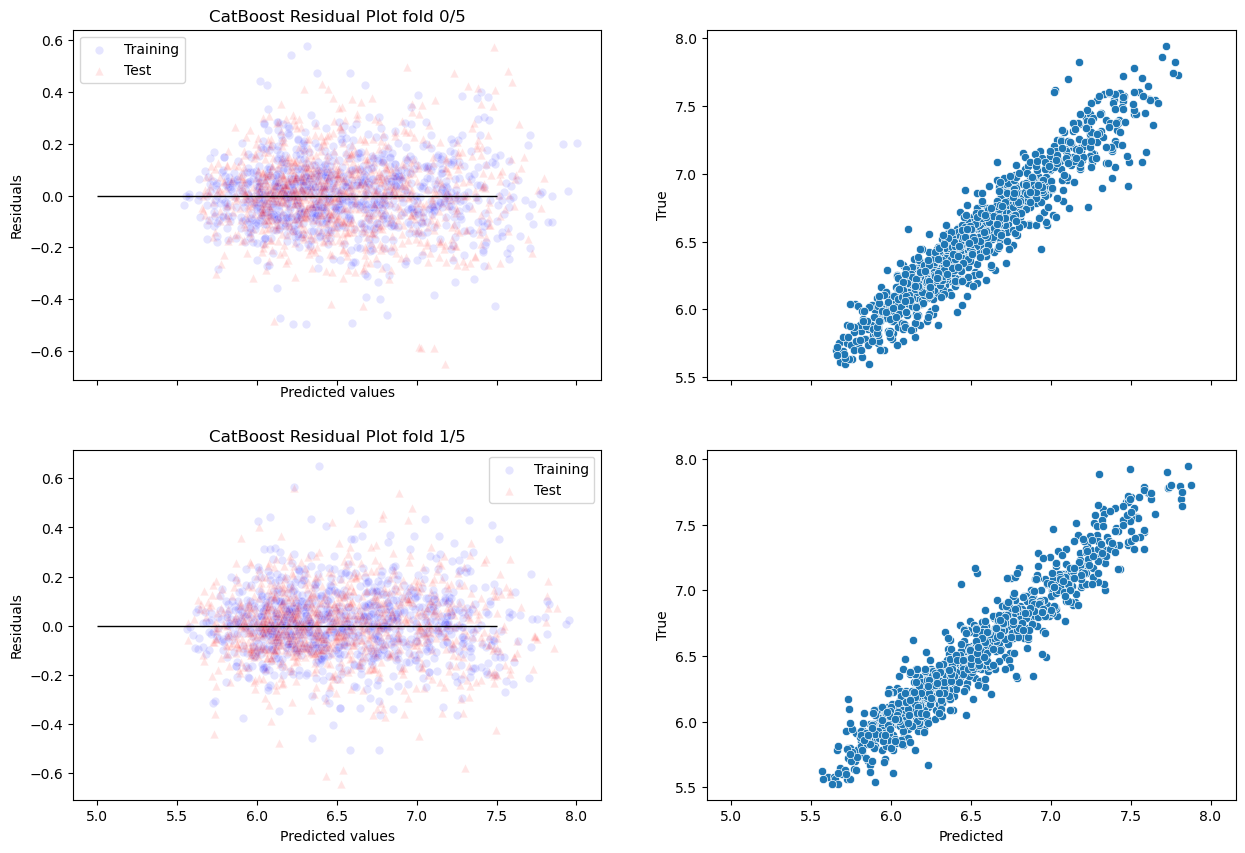

In [15]:
maxfold, num_folds = 2, 5
# model_name = 'LGBM'
model_name = 'CatBoost'

model_params = {
    'LGBM':{},
    'CatBoost': {
        'cat_features':cat_features, 
        # 'text_features':text_cols,        
        },
}

fig, axes = plt.subplots(ncols=2, nrows=maxfold, sharex=True, figsize=(15,int(5*maxfold)))

random_seed = 42
X, y = feats_df, target


# Create a cross-validation iterator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

# outer cross-validation 
records = []
models = []
# Iterate over the outer cross-validation folds
for ik, (train_index, valid_index) in enumerate(kf.split(X)):

    if ik >= maxfold: break

    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # tune the model with inner cross val
    res, optimum_params = tune(model_params[model_name], model_name, X_train, y_train, folds=(1,5), 
                               optimizer='gp', niter=15,
                               checkpointname=model_name, rstate=random_seed)
    print("Tuning complete with best params", optimum_params)

    # re-fit model
    model = get_model(name='CatBoost', params={**model_params[model_name],**optimum_params})

    t0 = time.time()
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the training and validation data
    y_train_pred = model.predict(X_train) 
    y_valid_pred = model.predict(X_valid) 

    # Calculate and store loss scores
    train_loss = calculate_loss(y_train, y_train_pred)
    valid_loss = calculate_loss(y_valid, y_valid_pred)

    models.append(model)
    records.append({  
        'model' : model_name,
        'outer_fold_k':ik,
        'train_loss':train_loss,
        'valid_loss':valid_loss,
        'valid_r2' : r2_score(y_valid, y_valid_pred),
        **optimum_params,
        })
    
    print(f"Outer CV: {ik+1}/{num_folds}, Val. loss: {valid_loss:.2f}, Time: {time.time()-t0:.1f}s")
    print('-'*30)

    n = 1000
    residual_plot(axes[ik,0], y_train[:n], y_train_pred[:n], 
                              y_valid[:n], y_valid_pred[:n], 
                title=f"CatBoost Residual Plot fold {ik}/{num_folds}")
    sns.scatterplot(y=y_valid[:n], x=y_valid_pred[:n], ax=axes[ik,1])
    axes[ik,1].set_xlabel('Predicted')
    axes[ik,1].set_ylabel('True')

records_df = pd.DataFrame(records)
records_df.to_csv(f'{model_name}_cvResults.csv')

In [16]:
records_df

,model,outer_fold_k,train_loss,valid_loss,valid_r2,learning_rate,depth,n_estimators,colsample_bylevel,one_hot_max_size,simple_ctr,combinations_ctr
0,CatBoost,0,0.137421,0.147021,0.912508,0.476375,7,650,0.304946,6,Buckets,Borders
1,CatBoost,1,0.137189,0.147892,0.910840,0.476375,7,650,0.304946,6,Buckets,Borders
